<a href="https://colab.research.google.com/github/SBalas/API_Data/blob/main/YouTubeAPI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Extracting info of videos from a YouTube channel using the YouTube API

This code is used to get all the video IDs and info of a YouTube channel. The YouTube API is called to gather the relvant information.

- YouTube API source page - https://developers.google.com/youtube/v3/getting-started
- Github for Google APIs - https://github.com/googleapis/google-api-python-client
- YouTube APIv3 info - https://googleapis.github.io/google-api-python-client/docs/dyn/youtube_v3.html

In [105]:
import googleapiclient.discovery
from IPython.display import JSON
import json
import pandas as pd


In [106]:
# Gordon Ramsay's YouTube Channel
# https://www.youtube.com/@gordonramsay

forHandle = '@gordonramsay'
#forHandle = '@JKenjiLopezAlt'


In [107]:
# API key stored in google collab secrets
from google.colab import userdata
api_key = userdata.get('Youtube_api_key')
api_service_name = "youtube"
api_version = "v3"

In [108]:
# Get credentials and create an API client
youtube = googleapiclient.discovery.build(
    api_service_name, api_version, developerKey = api_key)

request = youtube.channels().list(
    part = "snippet,contentDetails,statistics",
    forHandle = forHandle
)

response = request.execute()
#JSON(response)

In [109]:
# This function calls the YouTube channels API based on the forHandle (channel name)
# It then extracts relevant info about the channel and returns a dictionary

def channel_info(youtube, forHandle):

    '''
    Takes in the youtube instance and channel handle
    Returns a dictionary with info abou the channel
    '''

    # request the channels info from youtube build service
    request = youtube.channels().list(
        part = 'ContentDetails, statistics, snippet',
        forHandle = forHandle,
        maxResults = 50
    )

    # execute the request
    response = request.execute()

    # Go through the dictionary of 'response' to get the relevant data
    channelName = response['items'][0]['snippet']['title']
    channelId = response['items'][0]['id']

    playlistId = response['items'][0]['contentDetails']['relatedPlaylists']['uploads']

    viewCount = int(response['items'][0]['statistics']['viewCount'])
    subscriberCount = int(response['items'][0]['statistics']['subscriberCount'])
    videoCount = int(response['items'][0]['statistics']['videoCount'])

    # convert to dictionary
    data = {'channelName': channelName,
    'channelId': channelId,
    'playlistId': playlistId,
    'viewCount': viewCount,
    'subscriberCount': subscriberCount,
    'videoCount': videoCount
    }

    return data


In [110]:
channel_data = channel_info(youtube, forHandle)
channel_data

{'channelName': 'Gordon Ramsay',
 'channelId': 'UCIEv3lZ_tNXHzL3ox-_uUGQ',
 'playlistId': 'UUIEv3lZ_tNXHzL3ox-_uUGQ',
 'viewCount': 4394339729,
 'subscriberCount': 21400000,
 'videoCount': 1909}

In [111]:
# The playlistId is the Id that will be used to get all the video IDs later
playlistId = channel_data['playlistId']
playlistId

'UUIEv3lZ_tNXHzL3ox-_uUGQ'

In [112]:
# Call the playlistID API to get all the video IDs

request = youtube.playlistItems().list(
  part="contentDetails, snippet",
  playlistId = playlistId,
  maxResults = 50
)

response = request.execute()
#JSON(response)

## Function that calls the `playlistItems` API and gets all the video IDs

In [113]:
def get_videoId(youtube, playlistId):

  video_Ids = []
  nextPageToken = ''
  count = 0

  while nextPageToken is not None:

    request = youtube.playlistItems().list(
      part="contentDetails, snippet",
      maxResults = 50,
      playlistId = playlistId,
      pageToken = nextPageToken

    )

    response = request.execute()
    for dict in response['items']:
      video_Ids.append(dict['contentDetails']['videoId'])

    nextPageToken = response.get('nextPageToken')
    count += 1

    # To check the while loop
    #print(count)

  return video_Ids



In [114]:
# Call function to get all the video IDs
video_Ids = get_videoId(youtube, playlistId)
len(video_Ids)

1910

In [115]:
type(video_Ids)

list

## Function to call the `videos` API and get all the info about the videos

In [116]:
def get_video_info(youtube, video_Ids):

  '''
  Takes in the youtube instance and list of video IDs
  Returns a list of dictionaries that contain the info about the videos
  '''
  video_info = []

  for i in range(0, len(video_Ids), 50):

    # for loop to go through all the video IDs at steps of 50
    # 50 because that is the max number of videos that will be listed in the API page

    request = youtube.videos().list(
        part = 'contentDetails, snippet, statistics, topicDetails',
        maxResults = 50,
        id = ','.join(video_Ids[i:i+50])
        )

    response = request.execute()
    #JSON(response)



    for dict in response['items']:
      video_id = dict.get('id', 'NA')
      title_video = dict['snippet'].get('title', 'NA')
      publishedAt = dict['snippet'].get('publishedAt', 'NA')

      catgoryId = dict['snippet'].get('categoryId', 'NA')

      duration = dict['contentDetails'].get('duration', 'NA')
      caption = dict['contentDetails'].get('caption', 'NA')

      viewCount = dict['statistics'].get('viewCount', 'NA')
      likeCount = dict['statistics'].get('likeCount', 'NA')
      favoriteCount = dict['statistics'].get('favoriteCount', 'NA')
      commentCount = dict['statistics'].get('commentCount', 'NA')

      # convert to dictionary

      data = {
        'video_id': video_id,
        'title_video': title_video,
        'publishedAt': publishedAt,
        'catgoryId': catgoryId,
        'duration': duration,
        'caption': caption,

        'viewCount': viewCount,
        'likeCount': likeCount,
        'favoriteCount': favoriteCount,
        'commentCount': commentCount
      }

      video_info.append(data)

  return video_info

In [117]:
video_info = get_video_info(youtube, video_Ids)
video_df = pd.DataFrame(video_info)

In [118]:
video_df

,video_id,title_video,publishedAt,catgoryId,duration,caption,viewCount,likeCount,favoriteCount,commentCount
0,QOJT0XNee_o,Breakfast Sandwich Perfection: Gordon Ramsay’s...,2025-05-16T16:00:43Z,24,PT10M51S,false,122428,2546,0,352
1,ruy238T5TtU,24 HOURS TO HELL & BACK: Social | Gordon Ramsay,2025-05-14T22:00:56Z,24,PT42M20S,false,5097,121,0,12
2,AmbFriaXRhw,Gordon’s GREATEST Disguises | 24 Hours to Hell...,2025-05-12T16:00:15Z,24,PT34M6S,false,124505,2449,0,260
3,t9PKnaYN1hw,Gordon Ramsay’s Beef Lettuce Cups….perfect for...,2025-05-11T16:01:14Z,24,PT1M30S,false,721705,18648,0,364
4,-J1Gy79hVas,Gordon Ramsay's Ultimate Beef Lettuce Cups,2025-05-09T16:00:01Z,24,PT11M45S,false,89756,2363,0,187
...,...,...,...,...,...,...,...,...,...,...
1905,itd0Nd5AYN8,How to Present Prawn Cocktail | Gordon Ramsay,2009-11-04T10:03:37Z,24,PT2M14S,false,247270,3291,0,3
1906,qSHXG-5ShFk,How to Make Mayonnaise | Gordon Ramsay,2009-11-04T10:02:17Z,24,PT1M45S,false,10226417,107461,0,654
1907,-tZaY-bl5aM,Chris Moyles Strips While Louis Walsh and Kell...,2009-11-04T10:00:27Z,24,PT1M3S,false,25450,421,0,1
1908,j9aaBv5se68,Andi Peters is Better Than Chef | Gordon Ramsay,2009-11-04T09:59:57Z,24,PT55S,false,115190,1063,0,10


In [119]:
# Pre-process the data
video_df.isnull().any()

,0
video_id,False
title_video,False
publishedAt,False
catgoryId,False
duration,False
caption,False
viewCount,False
likeCount,False
favoriteCount,False
commentCount,False


In [120]:
video_df.columns

Index(['video_id', 'title_video', 'publishedAt', 'catgoryId', 'duration',
       'caption', 'viewCount', 'likeCount', 'favoriteCount', 'commentCount'],
      dtype='object')

In [121]:
# convert to numeric

video_df['viewCount'] = pd.to_numeric(video_df['viewCount'], errors = 'coerce')
video_df['likeCount'] = pd.to_numeric(video_df['likeCount'], errors = 'coerce')
video_df['favoriteCount'] = pd.to_numeric(video_df['favoriteCount'], errors = 'coerce')
video_df['commentCount'] = pd.to_numeric(video_df['commentCount'], errors = 'coerce')

In [122]:
topViewCount = video_df.sort_values(by = "viewCount", ascending = False)[:20][['title_video', 'viewCount']]
topViewCount

,title_video,viewCount
414,Let’s make a Steak Sandwich….#Ramsay style ! #...,73912850
1190,Kitchen Nightmare's Most Ridiculous Moments,67030267
1418,Gordon Ramsay Amazed By Caviar Farm | Gordon R...,62775388
1363,RAW Lamb & Half A Pre-Packaged Cake Leaves Gor...,60024304
1467,Gordon Ramsay Catches King Crab | Gordon Ramsay,52078729
1530,How To Make Slow Roasted Pork Belly | Gordon R...,46950186
1480,How To Master 5 Basic Cooking Skills | Gordon ...,39028779
1300,Important Cooking Skills With Gordon Ramsay,38598308
1197,The WORST Steaks On Kitchen Nightmares,36159656
1859,Gordon Ramsay Cooking In Disguise,35674695


In [123]:
topLikeCount = video_df.sort_values(by = "likeCount", ascending = False)[:20][['title_video', 'likeCount']]
topLikeCount

,title_video,likeCount
414,Let’s make a Steak Sandwich….#Ramsay style ! #...,2786971.0
1159,Gordon Ramsay’s 10 Millionth Subscriber Burger...,864604.0
1190,Kitchen Nightmare's Most Ridiculous Moments,838967.0
909,Gordon Ramsay Gets Egged by Tilly,837553.0
979,The Best Fast Food Recipes | Part One | Gordon...,781196.0
1418,Gordon Ramsay Amazed By Caviar Farm | Gordon R...,729550.0
1480,How To Master 5 Basic Cooking Skills | Gordon ...,713976.0
1363,RAW Lamb & Half A Pre-Packaged Cake Leaves Gor...,703738.0
1467,Gordon Ramsay Catches King Crab | Gordon Ramsay,587332.0
1051,Steve-O Shocks Gordon Ramsay While Making A So...,550784.0


In [124]:
topCommentCount = video_df.sort_values(by = "commentCount", ascending = False)[:20][['title_video', 'commentCount']]
topCommentCount

,title_video,commentCount
1190,Kitchen Nightmare's Most Ridiculous Moments,83626.0
1159,Gordon Ramsay’s 10 Millionth Subscriber Burger...,57505.0
1363,RAW Lamb & Half A Pre-Packaged Cake Leaves Gor...,46692.0
1418,Gordon Ramsay Amazed By Caviar Farm | Gordon R...,46515.0
1272,Hotel Owner REFUSED TO CLEAN HER OWN DIARRHEA ...,45635.0
414,Let’s make a Steak Sandwich….#Ramsay style ! #...,45278.0
1466,Gordon Ramsay Hunts & Cooks Wild Boar | Gordon...,40620.0
1462,Gordon Ramsay & A Vegetarian Cook A Beef Fillet,35526.0
1467,Gordon Ramsay Catches King Crab | Gordon Ramsay,33487.0
979,The Best Fast Food Recipes | Part One | Gordon...,33005.0


## Few Plots

In [125]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import matplotlib.ticker as ticker

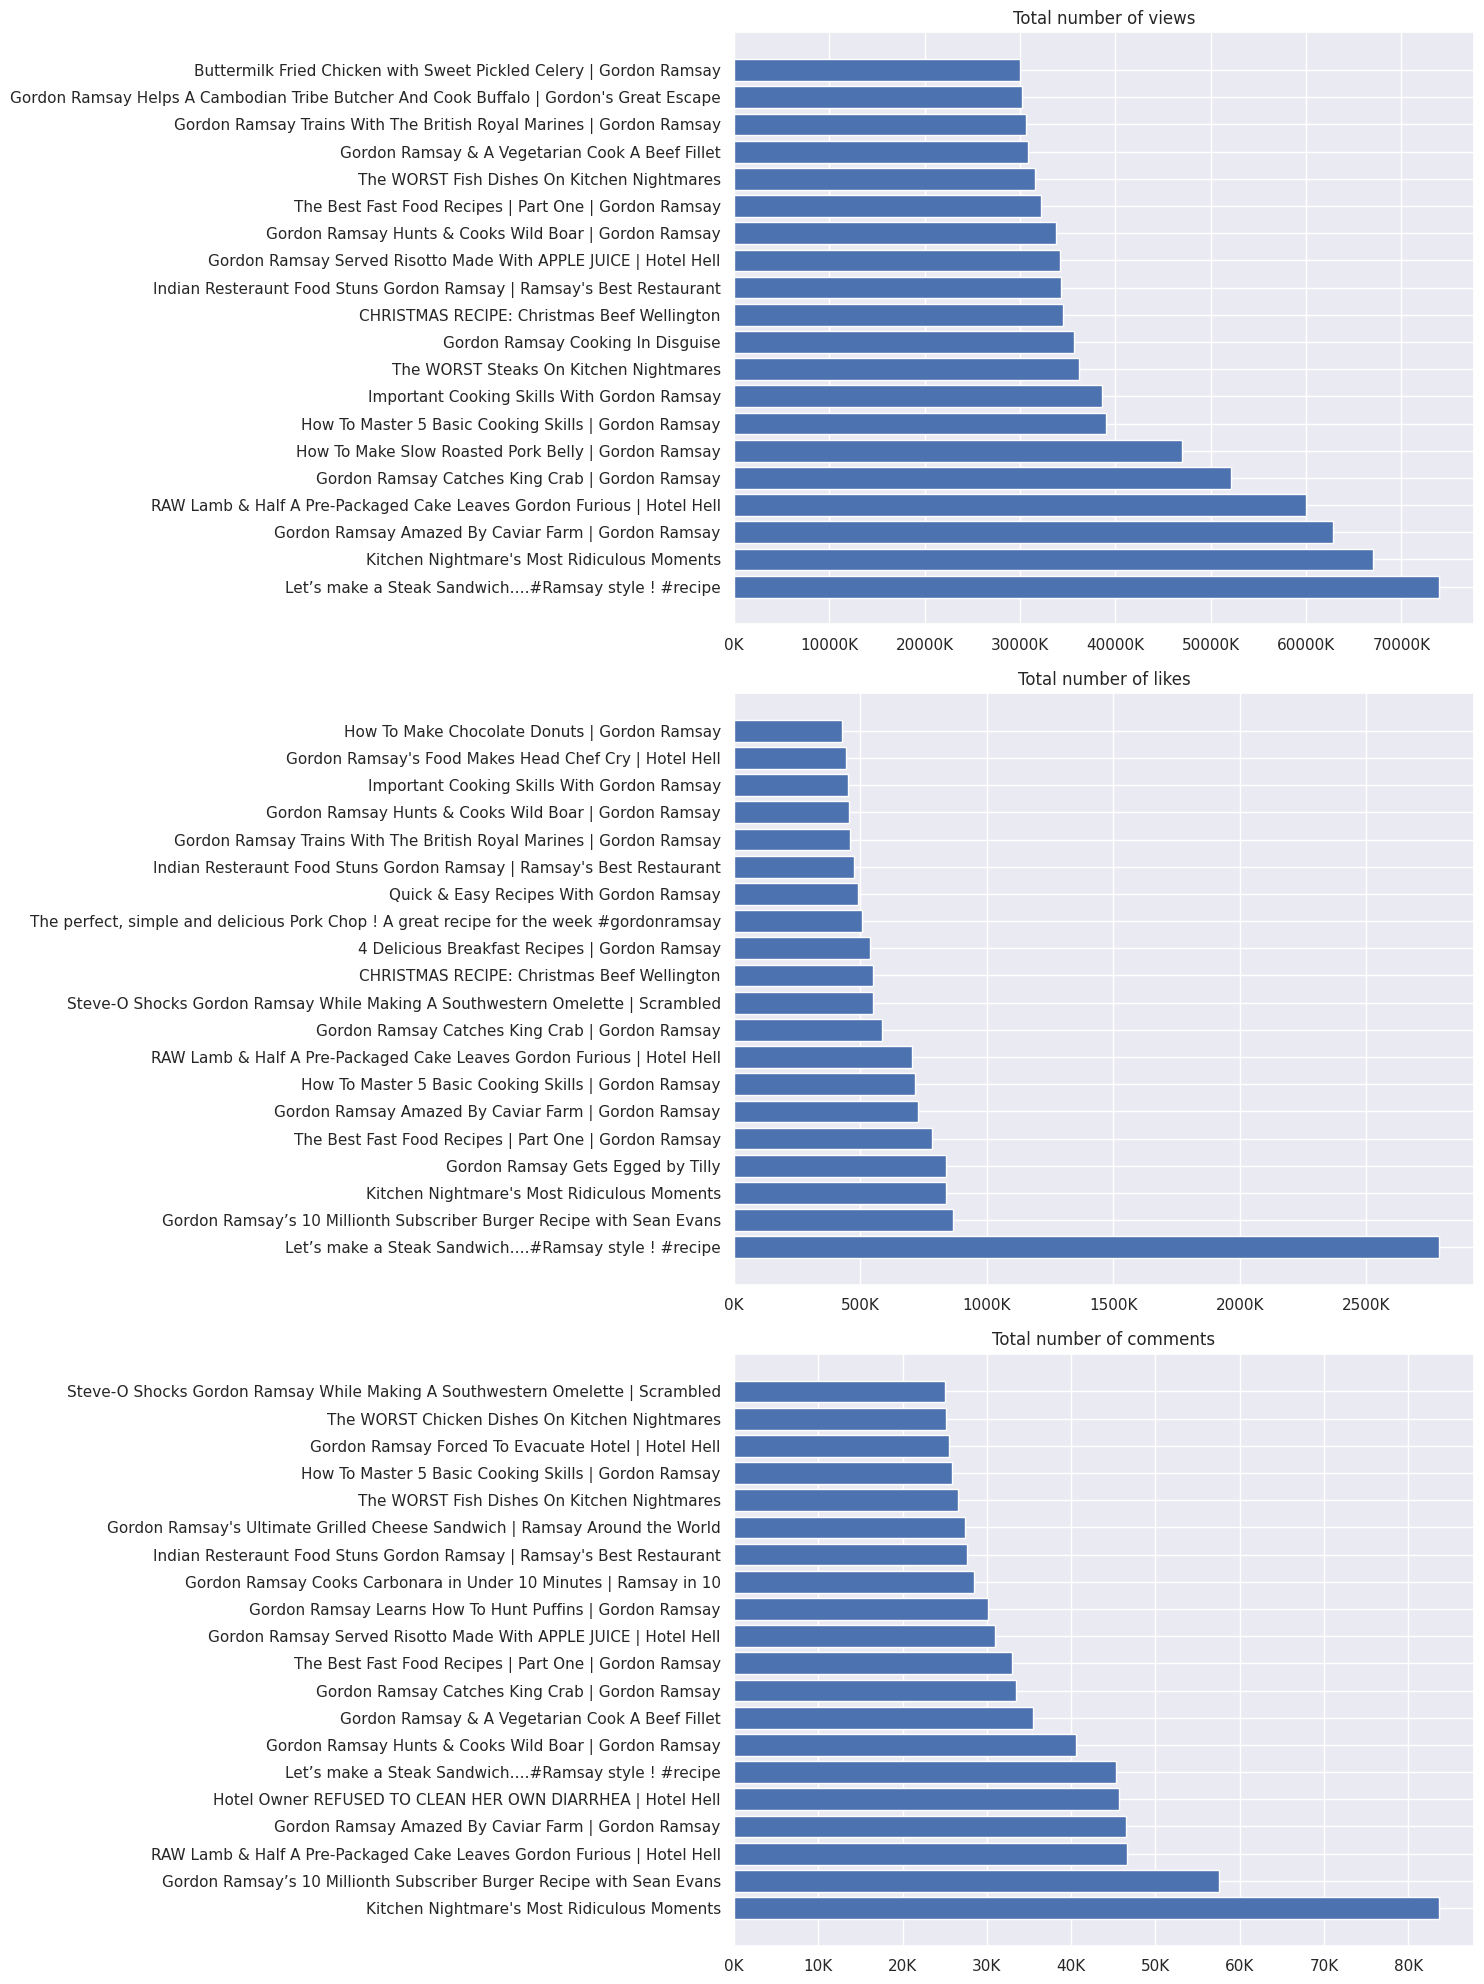

In [126]:
# Define the formatter function
# https://www.geeksforgeeks.org/formatting-axis-tick-labels-from-numbers-to-thousands-and-millions/#method-1-usingfuncformatter

def format_func(value, tick_number):
    return f'{int(value / 1000)}K'



plt.figure(figsize = (15,20))

plt.subplot(3,1,1)
plt.barh(topViewCount['title_video'], topViewCount['viewCount'])
plt.title('Total number of views')
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(format_func))

plt.subplot(3,1,2)
plt.barh(topLikeCount['title_video'], topLikeCount['likeCount'])
plt.title('Total number of likes')
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(format_func))

plt.subplot(3,1,3)
plt.barh(topCommentCount['title_video'], topCommentCount['commentCount'])
plt.title('Total number of comments')
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(format_func))

plt.tight_layout()




Example function to convert the youtube duration into total seconds

https://stackoverflow.com/questions/16742381/how-to-convert-youtube-api-duration-to-seconds

In [127]:
pip install isodate

In [128]:
import isodate
dur = isodate.parse_duration('P1W2DT6H21M32S')
print(dur.total_seconds())

800492.0


In [129]:
video_df['durationMin'] = video_df['duration'].apply(lambda x: isodate.parse_duration(x).total_seconds()/60)
video_df['durationMin'] = video_df['durationMin'].round(1)

In [130]:
video_df.head()

,video_id,title_video,publishedAt,catgoryId,duration,caption,viewCount,likeCount,favoriteCount,commentCount,durationMin
0,QOJT0XNee_o,Breakfast Sandwich Perfection: Gordon Ramsay’s...,2025-05-16T16:00:43Z,24,PT10M51S,false,122428,2546.0,0,352.0,10.8
1,ruy238T5TtU,24 HOURS TO HELL & BACK: Social | Gordon Ramsay,2025-05-14T22:00:56Z,24,PT42M20S,false,5097,121.0,0,12.0,42.3
2,AmbFriaXRhw,Gordon’s GREATEST Disguises | 24 Hours to Hell...,2025-05-12T16:00:15Z,24,PT34M6S,false,124505,2449.0,0,260.0,34.1
3,t9PKnaYN1hw,Gordon Ramsay’s Beef Lettuce Cups….perfect for...,2025-05-11T16:01:14Z,24,PT1M30S,false,721705,18648.0,0,364.0,1.5
4,-J1Gy79hVas,Gordon Ramsay's Ultimate Beef Lettuce Cups,2025-05-09T16:00:01Z,24,PT11M45S,false,89756,2363.0,0,187.0,11.8


Text(0, 0.5, 'Number of videos')

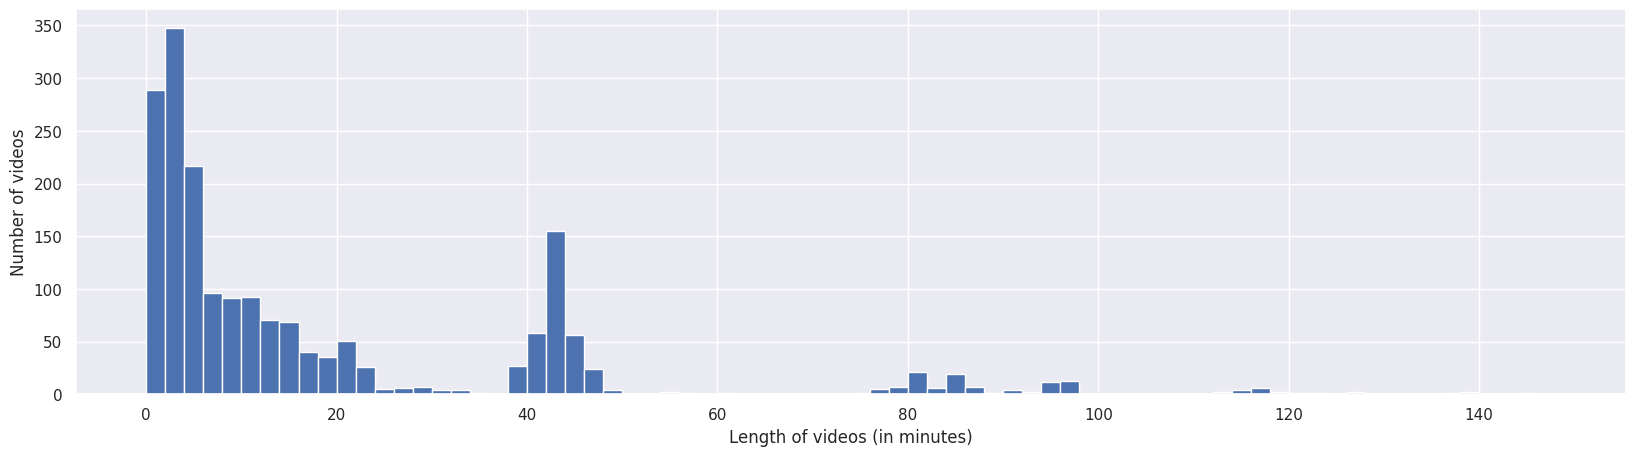

In [131]:
plt.figure(figsize = (20,5))
plt.hist(video_df['durationMin'], bins=range(0, 150, 2))
plt.xlabel('Length of videos (in minutes)')
plt.ylabel('Number of videos')

Text(0, 0.5, 'Number')

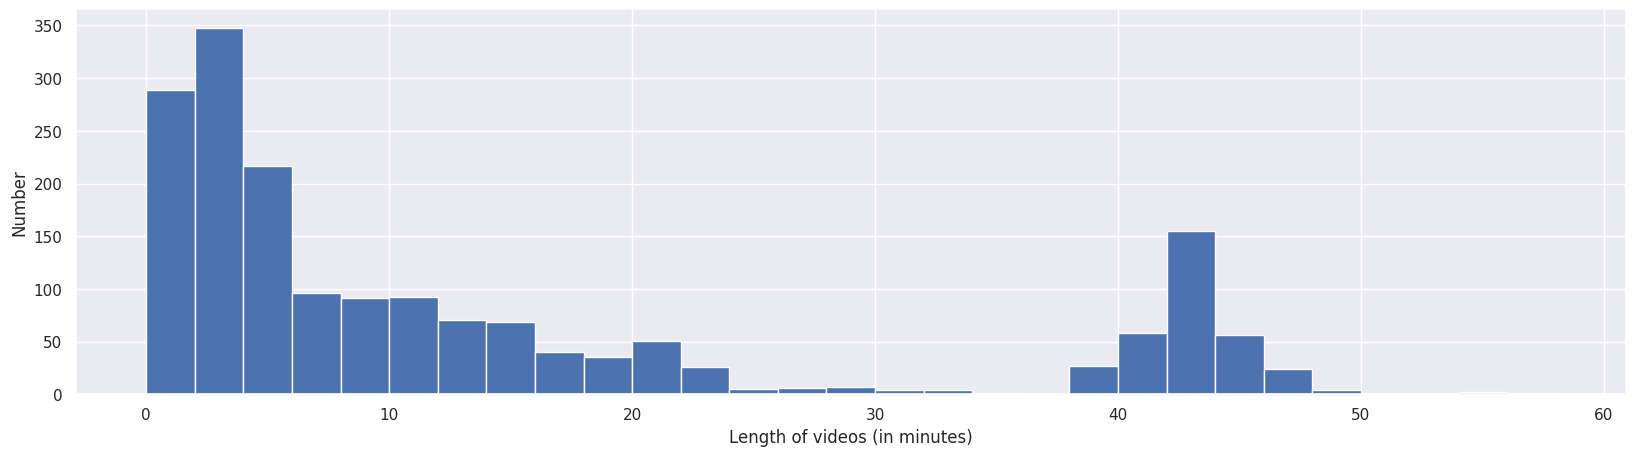

In [132]:
plt.figure(figsize = (20,5))
plt.hist(video_df['durationMin'], bins=range(0, 60, 2))
plt.xlabel('Length of videos (in minutes)')
plt.ylabel('Number')